In [1]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
tokenizer(["hola", "Cómo estás?"], truncation=True, padding="max_length", max_length=10)

{'input_ids': [[101, 16358, 1742, 102, 0, 0, 0, 0, 0, 0], [101, 140, 7774, 3702, 12890, 10014, 136, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}

In [24]:
from dataclasses import dataclass


@dataclass
class TransformerDecoderConfig:
    d_model: int = 512
    n_head: int = 4
    n_layer: int = 4
    d_ff: int = 2048
    dropout: float = 0.1
    activation: str = "gelu"
    ctx_len: int = 256
    d_vocab: int = 28996
    layer_norm_eps: float = 1e-5
    init_std: float = 0.02

cfg = TransformerDecoderConfig()

## Embeddings

In [25]:
import torch

W_E = torch.nn.Parameter(torch.empty(cfg.d_vocab, cfg.d_model))
torch.nn.init.normal_(W_E, mean=0, std=cfg.init_std)


Parameter containing:
tensor([[ 0.0241, -0.0368, -0.0094,  ..., -0.0308, -0.0152, -0.0081],
        [-0.0240,  0.0362, -0.0362,  ..., -0.0008,  0.0245,  0.0546],
        [ 0.0209, -0.0137,  0.0029,  ..., -0.0160,  0.0190,  0.0072],
        ...,
        [ 0.0294, -0.0014,  0.0278,  ..., -0.0375,  0.0198,  0.0008],
        [-0.0356,  0.0407, -0.0102,  ..., -0.0160,  0.0036,  0.0036],
        [ 0.0039,  0.0419, -0.0163,  ...,  0.0195, -0.0134, -0.0043]],
       requires_grad=True)

In [26]:
input_tensors = tokenizer(
    ["hola", "Cómo estás?"],
    truncation=True,
    padding="max_length",
    max_length=cfg.ctx_len,
    return_tensors="pt",
)["input_ids"]

In [36]:
embeddings = W_E[input_tensors]
embeddings.shape # batch_size, ctx_len, d_model

torch.Size([2, 256, 512])

In [35]:
W_E[input_tensors].shape

torch.Size([2, 256, 512])

## Positional Encoding

The original formula for positional encodins of the i-th token on embeddings of size d_model is:

$$PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})$$

$$PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})$$

where pos is the position and i is the dimension of the embedding.

Positional encodings can be represented as a single Matrix of size (ctx_len, d_model) where ctx_len is the maximum length of the context and d_model is the size of the embeddings.

In [65]:
# Positional encoding

def positional_encoding(ctx_len, d_model):
    pe = torch.zeros(ctx_len, d_model)
    position = torch.arange(0, ctx_len).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model)
    )
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)
    return pe

W_pe = positional_encoding(cfg.ctx_len, cfg.d_model)



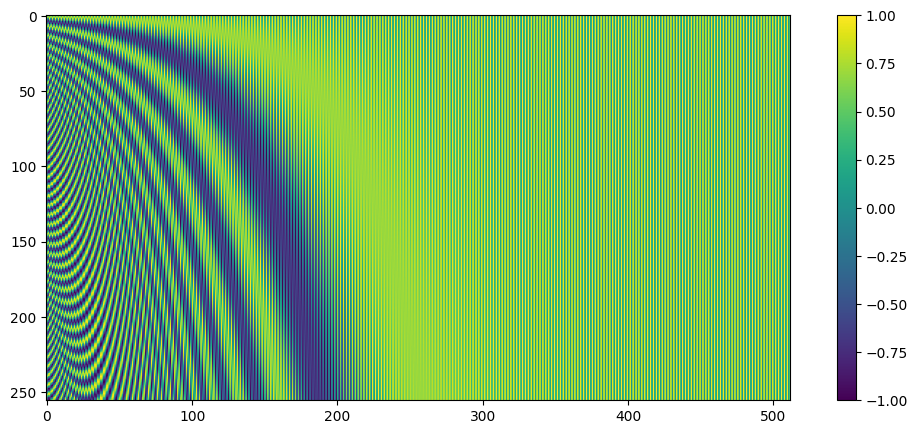

In [64]:
# Graph the Positional Encoding Matrix

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.imshow(W_pe, aspect="auto")
plt.colorbar()
plt.show()


In [52]:
embeddings.shape

torch.Size([2, 256, 512])

In [54]:
W_pe.shape

torch.Size([256, 512])

In [55]:
embeddings_pe = embeddings + W_pe
embeddings_pe.shape

torch.Size([2, 256, 512])

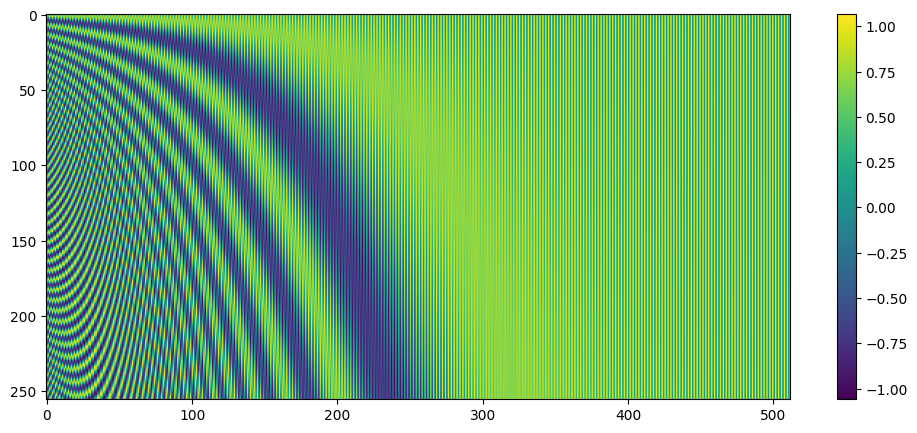

In [61]:

plt.figure(figsize=(12, 5))
plt.imshow(embeddings_pe[0].detach().numpy(), aspect="auto")
plt.colorbar()
plt.show()

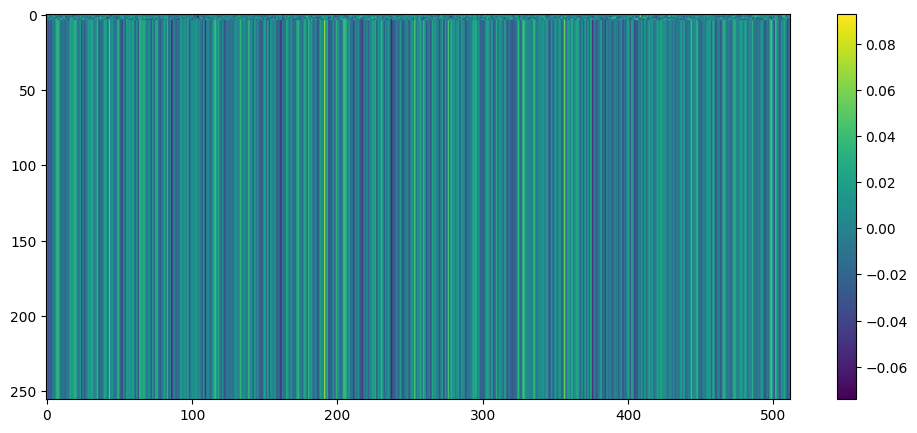

In [62]:
plt.figure(figsize=(12, 5))
plt.imshow(embeddings[0].detach().numpy(), aspect="auto")
plt.colorbar()
plt.show()